In [1]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

import seaborn as sns

import pandas as pd
import numpy as np
from random import choices
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [13]:
synthetic = pd.read_csv("synthetic.csv")
# synthetic.pop('gender')
synthetic.head()

,gender,admit,iq,sat
0,man,False,92.472816,959.728157
1,man,False,77.055728,862.557282
2,woman,False,96.986655,1046.866552
3,man,False,104.129996,1105.299959
4,man,False,101.215587,1047.155871


In [14]:
synthetic['admit'] = [0 if x == False else 1 for x in synthetic['admit']]
synthetic.describe()

,admit,iq,sat
count,5000.000000,5000.000000,5000.000000
mean,0.404000,100.037458,1045.088979
std,0.490747,19.909603,201.439475
min,0.000000,23.912771,271.127706
25%,0.000000,86.664101,908.881888
50%,0.000000,99.936357,1040.152307
75%,1.000000,113.993465,1185.707223
max,1.000000,159.906606,1688.765366


### Feature distribution

<AxesSubplot:xlabel='sat', ylabel='Density'>

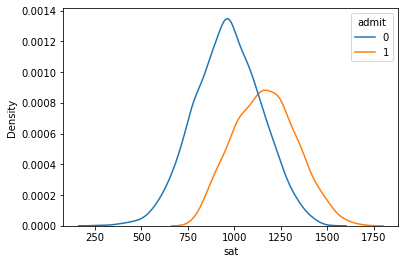

In [4]:
sns.kdeplot(synthetic['sat'],hue=synthetic['admit'])

<AxesSubplot:xlabel='iq', ylabel='Density'>

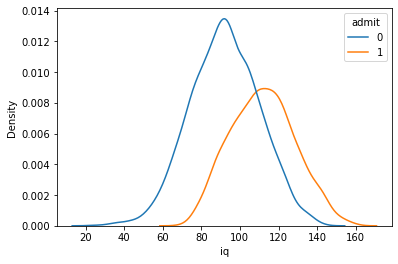

In [5]:
sns.kdeplot(synthetic['iq'],hue=synthetic['admit'])

### Distribution of positive labels 

In [6]:
counts = synthetic['admit'].value_counts().to_dict()
print(counts)
MCPc = counts[1]/(counts[0]+counts[0])*100
print("Percent of positive labels (Y = 1): {0:.2f}%".format(MCPc))

{0: 2980, 1: 2020}
Percent of positive labels (Y = 1): 33.89%


### Dependencies

In [7]:
def add_Fx(df_p,df_n,ppc, npc):
    """
    
    Add sensitive feature {0,1} to the dataframe
    
    parameter:
    - df_p   : dataframe for Y = 1
    - df_n   : dataframe for Y = 0
    - ppc    : percentage of S = 1 in Y = 0
    - npc    : percentage of S = 1 in Y = 0
    
    output:
    - X      : 8-dim array of independent variable
    - y      : 1-dim array of target variable
    
    """
    
    
    df_p.loc[:, 'Feature_X'] = choices([0,1],cum_weights = [ppc,100], k = len(df_p))
    df_n.loc[:, 'Feature_X'] = choices([0,1],cum_weights = [npc,100], k = len(df_n))
    dall = df_p.append(df_n)   
    
#     print("Distribution of Sensitive Attribute in Y = 1: {}".format(Counter(df_p['Feature_X'])))
#     print("Distribution of Sensitive Attribute in Y = 0: {}".format(Counter(df_n['Feature_X'])))
#     print("Distribution of Y (total): {}".format(Counter(dall['Class'])))
#     print("Distribution of Sensitive Attribute in Y (total): {}".format(Counter(dall['Feature_X'])))
    y = dall.pop("admit").values
    X = dall.values
    #print("Dimension of X after adding sensitive attribute: {}".format(X.shape))
    #print("Shape of y: {}".format(y.shape))
    return X, y 

def df_count_feat_val_match(df1, f1, v1, f2, v2):
    return len (df1[(df1[f1]==int(v1)) & (df1[f2]==int(v2))])

def underestimation_score(y_true,y_pred,SA):
    """
    
    parameter:
    - y_true : ground truth for prediction outcomes
    - y_pred : predicted outcomes
    - SA     : sensitive attributes
    
    output:
    - us_0: underestimation for S = 0
    - us_1: underestimation for S = 1
    
    """
    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',0)
    Bias_FX0 = P_dash_FX0/P_FX0
    
    if P_FX0 == 0:
        print("Divsion by zero detected!")
               
    return Bias_FX0

def UEI(sa, Y_train, Y_pred):
    us_df = {}
    us_df['sa'] = sa
    us_df['ytrain_actual'] = Y_train
    us_df['ytest_pred'] = Y_pred
    us_df = pd.DataFrame(us_df)

    prob_array = []
    for y in (0,1):
        for s in (0,1):
#             print((y,s))
            p_tilda = df_count_feat_val_match(us_df, 'ytrain_actual', y, 'sa',s)/len(us_df)
            p_hat = df_count_feat_val_match(us_df, 'ytest_pred', y, 'sa',s)/len(us_df)
#             print(p_hat,p_tilda)
            prob_array.append(   np.square(np.sqrt(p_hat)-np.sqrt(p_tilda))    )
    return np.sqrt(0.5*np.sum(prob_array))

def df_subsample_pos_class(all_df, rpc = 0, subsample = True):
    
    """
    
    Add sensitive feature {0,1} to the dataframe
    
    parameter:
    - all_df : original dataframe
    - rpc    : requested positive percentage to subsample
    
    output:
    - df_p      : dataframe for Y = 1 after subsampling
    - df_n      : dataframe for Y = 0
    
    """
    
    if subsample :
        rp = rpc/100 
        df_p = all_df[all_df['admit']==1].copy()
        df_n = all_df[all_df['admit']==0].copy()
        np = len(df_p)
        nn = len(df_n)
        perc_p = np/(np+nn)
    
        if rp > perc_p:
            print('Requested positive percentage (pcpc) is too high.',perc_p)
            return df_p, df_n
    
        np_dash = rp/(1-rp)* nn
        df_p = df_p.sample(int(np_dash+0.5))
    
        #print(np,nn,'--',np_dash)
        return df_p, df_n
    else:
        df_p = all_df[all_df['admit']==1].copy()
        df_n = all_df[all_df['admit']==0].copy()
        return df_p,df_n
    
def df_count_feat_val_match(df1, f1, v1, f2, v2):
    return len (df1[(df1[f1]==int(v1)) & (df1[f2]==int(v2))])

def optimize_model(clf,param,Xtrain,Xtest,y_train,y_test,scoring,cv):
    grid = GridSearchCV(clf,param,cv=cv,scoring=scoring,n_jobs=-1)
    grid.fit(Xtrain,y_train)
#     print("Classifier: {}".format(clf.__class__.__name__))
#     print("Best parameter: {}".format(grid.best_params_))
#     print("Best {}: {}".format(str(scoring),grid.best_score_))
#     print("-"*30)
    y_pred = grid.predict(Xtest)
    y_prob = grid.predict_proba(Xtest)
    return y_pred,grid.best_estimator_

## return best param
## return best score

def underestimation_score(y_true,y_pred,SA):
    """
    
    parameter:
    - y_true : ground truth for prediction outcomes
    - y_pred : predicted outcomes
    - SA     : sensitive attributes
    
    output:
    - us_0: underestimation for S = 0
    - us_1: underestimation for S = 1
    
    """
    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',0)
    Bias_FX0 = P_dash_FX0/P_FX0
    
    if P_FX0 == 0:
        print("Divsion by zero detected!")
               
    return Bias_FX0

def evaluate_model(y_true,y_pred,SA):
    """
    
    parameter:
    - y_true : ground truth for prediction outcomes
    - y_pred : predicted labels
    - y_prob : predicted probability
    - SA     : sensitive attributes in the test data
    
    output:
    - accuracy : accuracy scores
    - rocauc   : roc auc scores
    - us_0     : underestimation score for S = 0
    - us_1     : underestimation score for S = 1
    
    """
    Counter
    accuracy = accuracy_score(y_true,y_pred)
    b = underestimation_score(y_true,y_pred,SA)
    
    return accuracy,b


    
def preprocess_data(X,y):
    """
    Numerical features are scaled using MinMaxScaler, while categorical features one-hot-encoded.
    
    parameter:
    - X    : 8-dim array of independent variable
    - y    : 1-dim array of target variable
    
    output:
    - Xtrain      : 8-dim array containing independent variable in the train test
    - Xtest       : 8-dim array containing independent variable in the test set
    - y_train     : 1-dim array of target variable in the train set
    - y_test      : 1-dim array of target variable in the test set
    
    """
    
    minority_in_Pos = 0
    
    while not minority_in_Pos:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True, stratify = y)
        temp = pd.DataFrame({'Feature_X': X_test[:,2], 'admit': y_test}, columns=['Feature_X', 'admit'])
#         print(df_count_feat_val_match(temp, 'admit', 1, 'Feature_X',0) )
        minority_in_Pos = df_count_feat_val_match(temp, 'admit', 1, 'Feature_X',0)    

    minmax = MinMaxScaler()
    xtrain_num = minmax.fit_transform(X_train[:,0:2])
    xtest_num = minmax.transform(X_test[:,0:2])
    
    Xtrain = np.hstack((xtrain_num,X_train[:,2].reshape(-1,1)))
    Xtest = np.hstack((xtest_num,X_test[:,2].reshape(-1,1)))

#     print("Shape of train data: {}".format(Xtrain.shape))
#     print("Shape of test data : {}".format(Xtest.shape))
    
    return Xtrain,Xtest,y_train,y_test

In [31]:
models = {}
models['Tree'] = DecisionTreeClassifier(random_state = 0)
models['Gradient Boost'] = GradientBoostingClassifier(random_state = 0)
models['Random Forest'] = RandomForestClassifier(random_state=0,n_jobs=-1)
models['k-NN'] = KNeighborsClassifier(n_jobs=-1) 
models['Naive Bayes'] = GaussianNB()
models['Logistic Regression'] = LogisticRegression(max_iter=1000,n_jobs=-1,random_state=0) 
models['Neural Net'] = MLPClassifier(random_state=0) 

params = {}
params['Tree'] = {'criterion': ['gini','entropy'], 'max_depth': [1,2,3,4,7,8,9,13,14,16,20,22,23,5,10,25,40,50,75,100,125,150,175,200,300,400,500], 'min_samples_split':[5,10,50,100,150,200]}
params['Gradient Boost'] = {'n_estimators': [50,100,150,200,500], 'learning_rate': [0.001,0.01,0.1,1,10,100], 'max_depth' : list(np.arange(1,6)),'min_samples_leaf': [20,50,75,100,150,200], 'max_features': [1,0.4,0.1]}
params['Random Forest'] = {'n_estimators': [50,100,200,500,750,1000],'max_depth': [5,6,7,8,9,12,14,15,16,18,22,25,2810,20,50,100,150,200,400]}
params['k-NN'] = {'n_neighbors':[2,3,5,8,10,15,20,25]}
params['Naive Bayes'] = {'var_smoothing':[0.0000001,0.00000001]}
params['Logistic Regression'] = {'penalty': ['l1','l2','elasticnet','none'], 'C': [0.001,0.01,0.1,1,10,100,1000], 'class_weight' : ['balanced',None]}
params['Neural Net'] = {'hidden_layer_sizes': [(10,),(20,),(30,),(40,),(50,)], 'activation':['tanh','relu','logistic'],'solver':['lbfgs','adam','sgd'],'alpha':[0.1,1,2,5,7,10], 'learning_rate': ['constant','adaptive']}

In [32]:
def underestimation_score(y_true,y_pred,SA):
    """
    
    parameter:
    - y_true : ground truth for prediction outcomes
    - y_pred : predicted outcomes
    - SA     : sensitive attributes
    
    output:
    - us_0: underestimation for S = 0
    - us_1: underestimation for S = 1
    
    """
    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',0)
    Bias_FX0 = P_dash_FX0/P_FX0
    
    if P_FX0 == 0:
        print("Divsion by zero detected!")
               
    return Bias_FX0

def underestimation_score_pos(y_true,y_pred,SA):
    """
    
    parameter:
    - y_true : ground truth for prediction outcomes
    - y_pred : predicted outcomes
    - SA     : sensitive attributes
    
    output:
    - us_0: underestimation for S = 0
    - us_1: underestimation for S = 1
    
    """
    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',1)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',1)
    Bias_FX0 = P_dash_FX0/P_FX0
    
    if P_FX0 == 0:
        print("Divsion by zero detected!")
               
    return Bias_FX0

In [9]:
class_incidence = list(range(10, int(MCPc/10)*10+1, 5)) 
feature_incidence = list(range(10,51,5))
heatmap_DF = {}
result = []
best_model = {}

for model,param in zip(models,params):
    print("Model: {}".format(model))
    temp_heatmap = pd.DataFrame(columns=feature_incidence)
    for class_imb in class_incidence:
        accuracies = []
        biases = []
        for feature_imb in feature_incidence:
            print((class_imb,feature_imb))
            
            df_p,df_n = df_subsample_pos_class(synthetic,class_imb)
            X,y = add_Fx(df_p,df_n,feature_imb,40)
            
            acc = []
            roc = []
            bias = []
            
            for n in range(20):
                #progress bar
                print(">> {}".format(n+1))
                    
                Xtrain,Xtest,y_train,y_test = preprocess_data(X,y)
                y_pred,optimized_model = optimize_model(models[model],params[param],Xtrain,Xtest,y_train,y_test,"balanced_accuracy",10)
                    #print(y_pred)
                accuracy,bi = evaluate_model(y_test,y_pred,Xtest[:,2].ravel()) 
                acc.append(accuracy)
                bias.append(bi)
                    #print("US: {}".format(us_0))

            accuracies.append(np.median(acc))
            biases.append(np.median(bias))
            result.append([class_imb,feature_imb,model,np.median(acc),np.median(bias)])
        temp_heatmap.loc[class_imb] = biases
    heatmap_DF[model] = temp_heatmap

Model: Random Forest
(10, 10)
>> 1
>> 2
>> 3
>> 4
>> 5
>> 6
>> 7
>> 8
>> 9
>> 10
>> 11
>> 12
>> 13
>> 14
>> 15
>> 16
>> 17
>> 18
>> 19
>> 20
(10, 15)
>> 1
>> 2
>> 3
>> 4
>> 5
>> 6
>> 7
>> 8
>> 9
>> 10
>> 11
>> 12
>> 13
>> 14
>> 15
>> 16
>> 17
>> 18
>> 19
>> 20
(10, 20)
>> 1
>> 2
>> 3
>> 4
>> 5
>> 6
>> 7
>> 8
>> 9
>> 10
>> 11
>> 12
>> 13
>> 14
>> 15
>> 16
>> 17
>> 18
>> 19
>> 20
(10, 25)
>> 1
>> 2
>> 3
>> 4
>> 5
>> 6
>> 7
>> 8
>> 9
>> 10
>> 11
>> 12
>> 13
>> 14
>> 15
>> 16
>> 17
>> 18
>> 19
>> 20
(10, 30)
>> 1
>> 2
>> 3
>> 4
>> 5
>> 6
>> 7
>> 8
>> 9
>> 10
>> 11
>> 12
>> 13
>> 14
>> 15
>> 16
>> 17
>> 18
>> 19
>> 20
(10, 35)
>> 1
>> 2
>> 3
>> 4
>> 5
>> 6
>> 7
>> 8
>> 9
>> 10
>> 11
>> 12
>> 13
>> 14
>> 15
>> 16
>> 17
>> 18
>> 19
>> 20
(10, 40)
>> 1
>> 2
>> 3
>> 4
>> 5
>> 6
>> 7
>> 8
>> 9
>> 10
>> 11
>> 12
>> 13
>> 14
>> 15
>> 16
>> 17
>> 18
>> 19
>> 20
(10, 45)
>> 1
>> 2
>> 3
>> 4
>> 5
>> 6
>> 7
>> 8
>> 9
>> 10
>> 11
>> 12
>> 13
>> 14
>> 15
>> 16
>> 17
>> 18
>> 19
>> 20
(10, 50)
>> 1
>> 2


In [ ]:
ax = sns.heatmap(heatmap_DF['k-NN'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

In [ ]:
ax = sns.heatmap(heatmap_DF['Tree'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

In [ ]:
ax = sns.heatmap(heatmap_DF['Naive Bayes'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

In [ ]:
ax = sns.heatmap(heatmap_DF['Logistic Regression'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

In [ ]:
ax = sns.heatmap(heatmap_DF['Neural Net'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

Text(33.0, 0.5, 'Class Incidence')

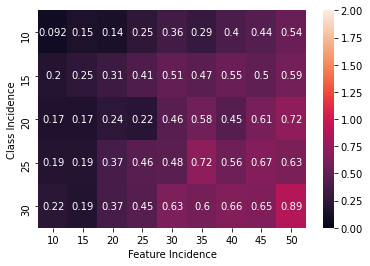

In [10]:
ax = sns.heatmap(heatmap_DF['Random Forest'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

Text(33.0, 0.5, 'Class Incidence')

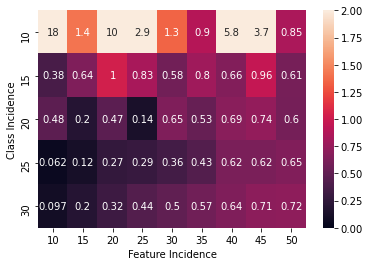

In [15]:
ax = sns.heatmap(heatmap_DF['Gradient Boost'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

In [ ]:
DF = pd.DataFrame(result, columns = ["Class Incidence","Feature Incidence","Model","Accuracy","ROCAUC",'Bias'])
DF.to_csv("result.csv")

### Optimized on Underestimation

In [23]:
models = {}
models['Tree'] = DecisionTreeClassifier(random_state = 0)
# models['Gradient Boost'] = GradientBoostingClassifier(random_state = 0)
# models['Random Forest'] = RandomForestClassifier(random_state=0,n_jobs=-1)
models['k-NN'] = KNeighborsClassifier(n_jobs=-1) 
models['Naive Bayes'] = GaussianNB()
models['Logistic Regression'] = LogisticRegression(max_iter=1000,n_jobs=-1,random_state=0) 
# models['Neural Net'] = MLPClassifier(random_state=0) 

params = {}
params['Tree'] = {'criterion': ['gini','entropy'], 'max_depth': [1,5,10,25,40,50,75,100,125,150,175,200,300,400,500], 'min_samples_split':[5,10,50,100,150,200]}
# params['Gradient Boost'] = {'n_estimators': [200,500], 'learning_rate': [0.001,0.01,0.1,1,10,100], 'max_depth' : list(np.arange(1,6)),
#                             'min_samples_leaf': [20,50,75,100,150,200], 'max_features': [1,0.4,0.1]}
# params['Random Forest'] = {'n_estimators': [200,500,750,1000], 'criterion': ['gini','impurity'],'max_depth': [5,10,20,50,100,150,200,400],'class_weight':['balanced',None]}
params['k-NN'] = {'n_neighbors':[2,3,5,8,10,15,20,25]}
params['Naive Bayes'] = {'var_smoothing':[0.0000001,0.00000001]}
params['Logistic Regression'] = {'penalty': ['l1','l2','elasticnet','none'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
# params['Neural Net'] = {'hidden_layer_sizes': [(10,),(20,),(30,),(40,),(50,)], 'activation':['tanh','relu','logistic'],'solver':['lbfgs','adam','sgd'],
#                         'alpha': [0.1,1,2,5,7,10], 'learning_rate': ['constant','adaptive']}

In [24]:
def US_scorer(clf, X_tst, y_tst):
    y_pred = clf.predict(X_tst)
    Fx_tst = [int(i) for i in X_tst[:,-1]]
    US_s = underestimation_score(y_tst,y_pred,Fx_tst)
    try:
        US = 1/(abs(1-US_s))
    except:
        US= 1/(abs((1-US_s))+0.0001)
    return US

def custom_loss_function(clf,X_tst,y_test):
    y_pred = clf.predict(X_tst)
    Fx_tst = [int(i) for i in X_tst[:,-1]]
    
    US_s = underestimation_score(y_test,y_pred,Fx_tst)
    try:
        US = 1/(abs(1-US_s))
    except:
#         print("smoothing added")
        US= 1/(abs((1-US_s))+0.0001)

    accuracy = accuracy_score(y_test,y_pred)
    
    weight_ACC = 0.5
    
    return (weight_ACC*accuracy) + ((1-weight_ACC) * US)

def underestimation_score(y_true,y_pred,SA):
    """
    
    parameter:
    - y_true : ground truth for prediction outcomes
    - y_pred : predicted outcomes
    - SA     : sensitive attributes
    
    output:
    - us_0: underestimation for S = 0
    - us_1: underestimation for S = 1
    
    """
    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)   


    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
    #print(P_dash_FX0)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',0)
    #print(P_FX0)
    Bias_FX0 = P_dash_FX0/P_FX0
    #print("="*40)
    return Bias_FX0

class_incidence = list(range(10, int(MCPc/10)*10+1, 5)) 
feature_incidence = list(range(10,51,5))
heatmap_DF = {}
result = []
best_model = {}

for model,param in zip(models,params):
    print("Model: {}".format(model))
    temp_heatmap = pd.DataFrame(columns=feature_incidence)
    for class_imb in class_incidence:
        accuracies = []
        biases = []
        for feature_imb in feature_incidence:
            print((class_imb,feature_imb))
            
            df_p,df_n = df_subsample_pos_class(synthetic,class_imb)
            X,y = add_Fx(df_p,df_n,feature_imb,40)
            
            acc = []
            bias = []
            
            for n in range(20):
                #progress bar
                if n in [5,10,15,20]:
                    print(">> {}".format(n))
                    
                
                if n == 0:
                    for xx in range(10):
                        try:
                            Xtrain,Xtest,y_train,y_test = preprocess_data(X,y)
                            y_pred,optimized_model = optimize_model(models[model],params[param],Xtrain,Xtest,y_train,y_test,custom_loss_function,10)
                            break
                        except:
                            print("Division by zero detected!")
                            pass
                        
                    #print(y_pred)
                    accuracy,bi = evaluate_model(y_test,y_pred,Xtest[:,2].ravel()) 
                    acc.append(accuracy)
                    bias.append(bi)
                    best_model[model] = optimized_model
                    #print("US: {}".format(us_0))
                else:
                    #print(models[model])
                    #print(grid)
                    optimized_model.fit(Xtrain,y_train)
                    y_pred = optimized_model.predict(Xtest)
                    #print(y_pred)
                    accuracy,bi = evaluate_model(y_test,y_pred,Xtest[:,2].ravel())
                    acc.append(accuracy)
                    bias.append(bi)
#                 print("="*40)
            accuracies.append(np.median(acc))
            biases.append(np.median(bias))
            result.append([class_imb,feature_imb,model,np.median(acc),np.median(bias)])
        temp_heatmap.loc[class_imb] = biases
    heatmap_DF[model] = temp_heatmap

Model: Tree
(10, 10)
Division by zero detected!
>> 5
>> 10
>> 15
(10, 15)
Division by zero detected!
>> 5
>> 10
>> 15
(10, 20)
>> 5
>> 10
>> 15
(10, 25)
>> 5
>> 10
>> 15
(10, 30)
>> 5
>> 10
>> 15
(10, 35)
>> 5
>> 10
>> 15
(10, 40)
>> 5
>> 10
>> 15
(10, 45)
>> 5
>> 10
>> 15
(10, 50)
>> 5
>> 10
>> 15
(15, 10)
>> 5
>> 10
>> 15
(15, 15)
>> 5
>> 10
>> 15
(15, 20)
>> 5
>> 10
>> 15
(15, 25)
>> 5
>> 10
>> 15
(15, 30)
>> 5
>> 10
>> 15
(15, 35)
>> 5
>> 10
>> 15
(15, 40)
>> 5
>> 10
>> 15
(15, 45)
>> 5
>> 10
>> 15
(15, 50)
>> 5
>> 10
>> 15
(20, 10)
>> 5
>> 10
>> 15
(20, 15)
>> 5
>> 10
>> 15
(20, 20)
>> 5
>> 10
>> 15
(20, 25)
>> 5
>> 10
>> 15
(20, 30)
>> 5
>> 10
>> 15
(20, 35)
>> 5
>> 10
>> 15
(20, 40)
>> 5
>> 10
>> 15
(20, 45)
>> 5
>> 10
>> 15
(20, 50)
>> 5
>> 10
>> 15
(25, 10)
>> 5
>> 10
>> 15
(25, 15)
>> 5
>> 10
>> 15
(25, 20)
>> 5
>> 10
>> 15
(25, 25)
>> 5
>> 10
>> 15
(25, 30)
>> 5
>> 10
>> 15
(25, 35)
>> 5
>> 10
>> 15
(25, 40)
>> 5
>> 10
>> 15
(25, 45)
>> 5
>> 10
>> 15
(25, 50)
>> 5
>> 10
>> 1

Text(33.0, 0.5, 'Class Incidence')

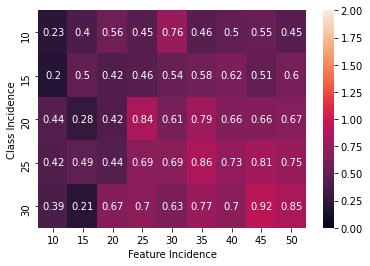

In [19]:
ax = sns.heatmap(heatmap_DF['k-NN'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

Text(33.0, 0.5, 'Class Incidence')

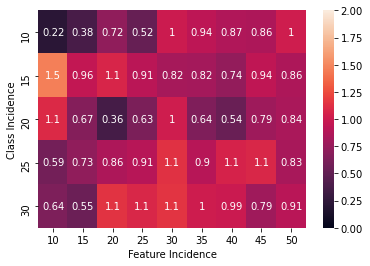

In [20]:
ax = sns.heatmap(heatmap_DF['Tree'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

Text(33.0, 0.5, 'Class Incidence')

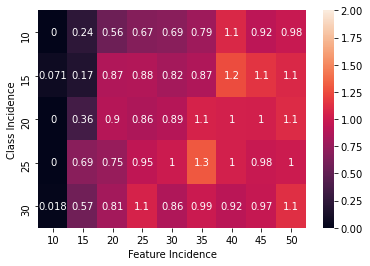

In [21]:
ax = sns.heatmap(heatmap_DF['Naive Bayes'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

Text(33.0, 0.5, 'Class Incidence')

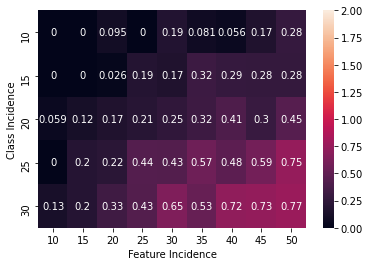

In [22]:
ax = sns.heatmap(heatmap_DF['Logistic Regression'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

In [ ]:
ax = sns.heatmap(heatmap_DF['Neural Net'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

In [ ]:
ax = sns.heatmap(heatmap_DF['Random Forest'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

In [ ]:
ax = sns.heatmap(heatmap_DF['Gradient Boost'], vmin = 0, vmax =2, annot=True)
ax.set_xlabel("Feature Incidence")
ax.set_ylabel("Class Incidence")

In [22]:
DF = pd.DataFrame(result, columns = ["Class Incidence","Feature Incidence","Model","Accuracy","ROCAUC",'Bias'])
DF.to_csv("result_US.csv")

In [30]:
nums = [1,2,3,4]
sum(nums[0:0])

0